# Import libraries

In [1]:
# Python libraries
import os
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.defs.myfun_models import *
# from ipynb.fs.full.myfun_plot import *

In [2]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense # for creating regular densely-connected NN layers.
import keras.metrics as metrics

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.model_selection import train_test_split # for splitting data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics

# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version

2023-08-14 10:37:38.247414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
pandas: 1.5.3
numpy: 1.23.5
sklearn: 1.3.0
plotly: 5.9.0


# Data Acquisition

In [3]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post') # we have 10 pandas dataframe, one for each couple(camera,sequence)

> **WARNING:**
> I have to standardize the data?

# Train and Evaluate a Neural Network

## Step 1: Select data for modeling

* X will be the consective distances btw vehicles and v0
* y will be the solution of our NN driven ODE model

In [4]:
# For sake of simplicity conseder only a scene
df = dflist[0] # fix a sequence
scn = df.T[0]  # fix a scene

In [5]:
scn

Tarr           [9.440000000000001, 9.64, 9.840000000000002, 1...
Xarr           [[29.373325674060805, 34.22142942994519, 38.50...
Cons Dis       [[28.985128254938463, 28.827356057195246, 29.0...
N. vehicles                                                    3
cam                                                            1
day                                                            1
seq                                                            1
N. file                                                        1
Name: 0, dtype: object

### Create X

>! **WARNING**: Chi è X? il rhs del modello ANN?

In [6]:
cd = scn['Cons Dis']
cd_initial = cd[:,0]            # consecutive distances btw vehicles at initial time
#v0 = np.random.rand()*10
v0 = 30
X = np.append(cd_initial,v0) 

In [7]:
v0, X

(30, array([28.98512825,  1.78659013, 30.        ]))

### Create y

we need to simulate our NN driven ODE model

In [8]:
# time discretization
tstamps = scn['Tarr']                  # timestamps scene

deltat = 0.05
factor = int(0.2/deltat)               # to get back the same timestamps
t0, tf = tstamps[0], tstamps[-1]       # initial and final time
Nt = int((tf-t0)/deltat) + 1           # number of discretization points (we need to cast the value)
tspan = np.linspace(t0, tf, Nt)        # timespan

N = scn['N. vehicles']                      # numbers of vehicles
# X0 = sorted(np.random.uniform(size=N)*100)  # initial condition
X0 =  scn['Xarr'][:,0]  # initial condition

> Cambia x0 con le posizioni iniizali già in Xarr
> X non è Xarr ma COns dis

In [9]:
# check that we have the same timestamps:
tstamps, tspan[::factor]

(array([ 9.44,  9.64,  9.84, 10.04, 10.24, 10.44]),
 array([ 9.44,  9.64,  9.84, 10.04, 10.24, 10.44]))

In [10]:
# For a single argument do not forget to add the comma in the tuple e.g.
vel = X
sol = odeint(TD_ANN_model, X0, tspan, args=(vel,), tfirst = True).T

In [11]:
if len(set(tstamps - tspan[::factor])) == 1:
    y = sol[:,::factor]
else:
    print(f"There is a mismatch in the timestamps: tstamps != tspan[::factor]")

In [12]:
y

array([[29.37332567, 35.17035133, 40.96737698, 46.76440263, 52.56142828,
        58.35845393],
       [58.35845393, 58.71577196, 59.07308998, 59.43040801, 59.78772604,
        60.14504406],
       [60.14504406, 66.14504406, 72.14504406, 78.14504406, 84.14504406,
        90.14504406]])

### Comparing trajectories of our scene and the one predicted in y

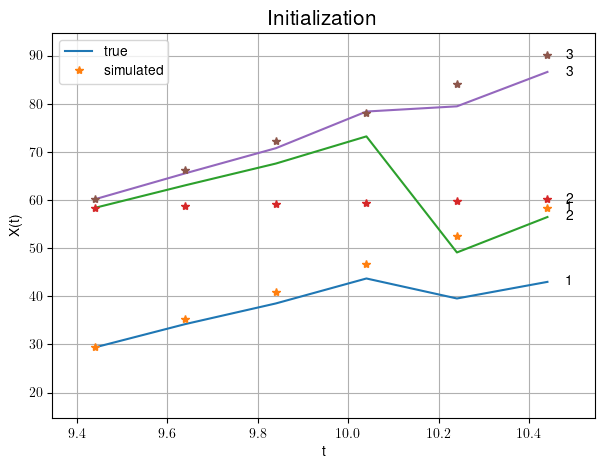

In [13]:
# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

N = scn['N. vehicles']

for veh in range(0,N):
    ax.plot(tstamps, scn['Xarr'][veh])
    ax.plot(tspan[::factor], y[veh], '*')


# Annotate the name of each variable at the last value
scale = 1.004
labels = list(range(1,N+1,1))

for ycoord in [scn['Xarr'],y]:
    coords = zip([tf*scale]*N,ycoord[:,-1]) # last value where I want to annotate the corresponding label
    for coord,lab in zip(coords,labels):
        ax.annotate(xy=coord,                    # The point (x, y) to annotate.
                    xytext=coord,                # The position (x, y) to place the text at.
    #                 textcoords='offset points',
                    text=lab,
                    verticalalignment='center')


ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(f"Initialization", fontsize=15)
xbal = 0.01
ybal = 0.05
ax.set_xlim(tstamps[0]*(1-xbal), tstamps[-1]*(1+xbal))
mmin, mmax = min(y.min(),scn['Xarr'].min()), max(y.max(),scn['Xarr'].max())
ax.set_ylim(mmin*(1-10*ybal), mmax*(1+ybal))
plt.legend(["true","simulated"])
plt.grid()
plt.show()

## Step 2: Create training and testing samples

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

> !**WARNING**:\
> It doesn't make sense t split X and y\
> to add randomness we need to choose a particular sequence instead of all the dataset?

## Step 3: Specify the structure of a Neural Network (1-2-1)

In [15]:
model = Sequential(name="Model-with-One-Input") # Model

# Input Layer - need to speicfy the shape of inputs
model.add(Input(shape=(1,), name='Input-Layer'))

# Hidden Layer, softplus(x) = log(exp(x) + 1)
model.add(Dense(2, activation='softplus', use_bias=True, name='Hidden-Layer'))

# Output Layer, linear(x) = x
model.add(Dense(1, activation='linear', use_bias=True, name='Output-Layer'))

In [16]:
model.summary()

Model: "Model-with-One-Input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer (Dense)        (None, 2)                 4         
                                                                 
 Output-Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


## Step 4: Compile keras model

In [17]:
# mae = tf.keras.losses.MeanAbsoluteError()

# loss_fun = mean(abs(y_true - y_pred))

In [18]:
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. tf.keras.losses.Loss instance.
              metrics=[metrics.mae] # List of metrics to be evaluated by the model during training and testing.
           )

## Step 5: Fit keras model on the dataset

In [19]:
model.fit(X, # input data
          y, # target data
          batch_size=10, # default=32, Number of samples per gradient update.
          epochs=3, # default=1, Number of epochs to train the model.
                    # An epoch is an iteration over the entire x and y data provided
          verbose='auto'
        )

Epoch 1/3
1/1 [==============================] - 0s 381ms/step - loss: 3764.6594 - mean_absolute_error: 59.4457
Epoch 2/3
1/1 [==============================] - 0s 6ms/step - loss: 3764.5095 - mean_absolute_error: 59.4444
Epoch 3/3
1/1 [==============================] - 0s 8ms/step - loss: 3764.3601 - mean_absolute_error: 59.4432


## Step 6: Use model to make predictions

In [20]:
# # Predict class labels on training data
# pred_labels_tr = (model.predict(X_train) > 0.5).astype(int)
# # Predict class labels on a test data
# pred_labels_te = (model.predict(X_test) > 0.5).astype(int)

y_pred = model.predict(X)

1/1 [==============================] - 0s 116ms/step


In [53]:
def get_test_stats(model, xtest, ytest, verbose_flag):
    
    # Compute LOSS and MAE on Test set
    loss, mae = model.evaluate(xtest, ytest, verbose = verbose_flag);
    
    y_pred = model.predict(xtest)
    weights = model.get_weights() # Getting params

    
    return loss, mae, y_pred, weights

In [54]:
loss, mae, y_pred, weights = get_test_stats(model, X, y, verbose_flag = 1)

1/1 [==============================] - 0s 22ms/step


In [57]:
print(
'- Stats:',
'\n\t* Loss:\t\t', loss,
'\n\t* MAE:\t\t', mae,
'\n\t* y_pred:\t', y_pred.tolist()
)

- Stats: 
	* Loss:		 3764.210205078125 
	* MAE:		 59.441925048828125 
	* y_pred:	 [[0.0029996666125953197], [-0.06909048557281494], [0.0029997846577316523]]


## Step 7: Model Performance Summary

In [24]:
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
for layer in model.layers:
    print("Layer: ", layer.name) # print layer name
    print("  --Kernels (Weights): ", layer.get_weights()[0]) # kernels (weights)
    print("  --Biases: ", layer.get_weights()[1]) # biases
    
print("")
# print('---------- Evaluation on Training Data ----------')
# print(classification_report(y_train, pred_labels_tr))
# print("")

# print('---------- Evaluation on Test Data ----------')
# print(classification_report(y_test, pred_labels_te))
# print("")


-------------------- Model Summary --------------------
Model: "Model-with-One-Input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer (Dense)        (None, 2)                 4         
                                                                 
 Output-Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Layer:  Hidden-Layer
  --Kernels (Weights):  [[-0.47013143 -1.0093865 ]]
  --Biases:  [-0.00299941  0.00300088]
Layer:  Output-Layer
  --Kernels (Weights):  [[-0.25844148]
 [ 0.1335816 ]]
  --Biases:  [0.00299998]



## Step 8: Solve the ODE with the output of the ANN

In [25]:
# For a single argument do not forget to add the comma in the tuple e.g.
sol_ann = odeint(TD_ANN_model, X0, tspan, args=(y_pred[:,0],), tfirst = True).T
y_ann = sol_ann[:,::factor]

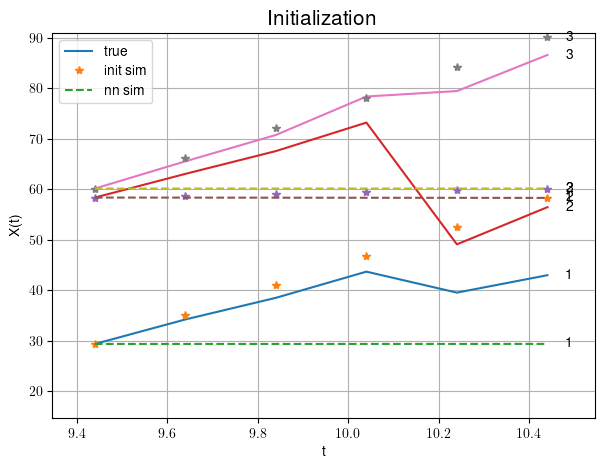

In [26]:
# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

N = scn['N. vehicles']

for veh in range(0,N):
    ax.plot(tstamps, scn['Xarr'][veh])
    ax.plot(tspan[::factor], y[veh], '*')
    ax.plot(tspan[::factor], y_ann[veh], '--')


# Annotate the name of each variable at the last value
scale = 1.004
labels = list(range(1,N+1,1))

for ycoord in [scn['Xarr'],y,y_ann]:
    coords = zip([tf*scale]*N,ycoord[:,-1]) # last value where I want to annotate the corresponding label
    for coord,lab in zip(coords,labels):
        ax.annotate(xy=coord,                    # The point (x, y) to annotate.
                    xytext=coord,                # The position (x, y) to place the text at.
    #                 textcoords='offset points',
                    text=lab,
                    verticalalignment='center')


ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(f"Initialization", fontsize=15)
xbal = 0.01
ybal = 0.05
ax.set_xlim(tstamps[0]*(1-xbal), tstamps[-1]*(1+xbal))
mmin, mmax = min(y_ann.min(),scn['Xarr'].min()), max(y_ann.max(),scn['Xarr'].max())
ax.set_ylim(mmin*(1-10*ybal), mmax*(1+ybal))
plt.legend(["true","init sim","nn sim"])
plt.grid()
plt.show()